인명 후보 Histogram
====

* 코퍼스로부터 인명 후보를 추출하고 각종 히스토그램을 그려 본다.
* 인명 후보는 아래 조건에 해당한다.
    - 단일 형태소
    - 품사가 NNP 혹은 NNG
    - 2~3음절

In [1]:
from __future__ import unicode_literals
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# JSON 문서(train/dev)를 읽어들인다.

import json

dev_json = json.load(open('../data/distribution2016/dev.json'))
train_json = json.load(open('../data/distribution2016/train.json'))

In [3]:
# JSON에서 인명 후보에 해당하는 형태소를 모두 추출하여 실제로 단일 형태소로 인명인 지 여부와 함께 저장한다.

from collections import namedtuple

Candidate = namedtuple('Candidate', ['lemma', 'tag', 'is_ps'])

candidates = []    # NNP+NNG, 2+3에 해당하는 모든 형태소
for sentence in train_json['sentence']:
    # 단일 형태소 이며(begin == end), 인명(PS)인 NE의 시작 위치(begin) 집합
    ne_set = set([ne['begin'] for ne in sentence['NE'] if ne['type'] == 'PS' and ne['begin'] == ne['end']])

    morps = sentence['morp']
    for morp in sentence['morp']:
        tag = morp['type']
        if tag not in ['NNP', 'NNG']:
            continue
        lemma = morp['lemma']
        if len(lemma) not in [2, 3]:
            continue
        is_ps = morp['id'] in ne_set
        candidates.append(Candidate(lemma, tag, is_ps))

In [4]:
# 음절 길이, 품사, 개체명 여부 별로 구분한 데이터프레임을 만든다.

df = pd.DataFrame.from_dict({'len': [len(_.lemma) for _ in candidates],
                             'tag': [_.tag for _ in candidates],
                             'is_ps': [1 if _.is_ps else 0 for _ in candidates],
                             'not_ps': [0 if _.is_ps else 1 for _ in candidates]})
print(df.describe())
df.sample(10)

              is_ps           len        not_ps
count  36238.000000  36238.000000  36238.000000
mean       0.048678      2.211684      0.951322
std        0.215197      0.408508      0.215197
min        0.000000      2.000000      0.000000
25%        0.000000      2.000000      1.000000
50%        0.000000      2.000000      1.000000
75%        0.000000      2.000000      1.000000
max        1.000000      3.000000      1.000000


,is_ps,len,not_ps,tag
35013,0,2,1,NNG
9968,0,2,1,NNG
34749,0,3,1,NNG
17433,0,2,1,NNG
20561,0,3,1,NNG
5472,0,2,1,NNP
20638,0,3,1,NNG
26466,0,3,1,NNG
128,0,2,1,NNG
3597,0,2,1,NNG


개체명 비율
----

         is_ps  not_ps
len tag               
2   NNG     63   26212
    NNP    196    2096
3   NNG     17    4746
    NNP   1488    1420


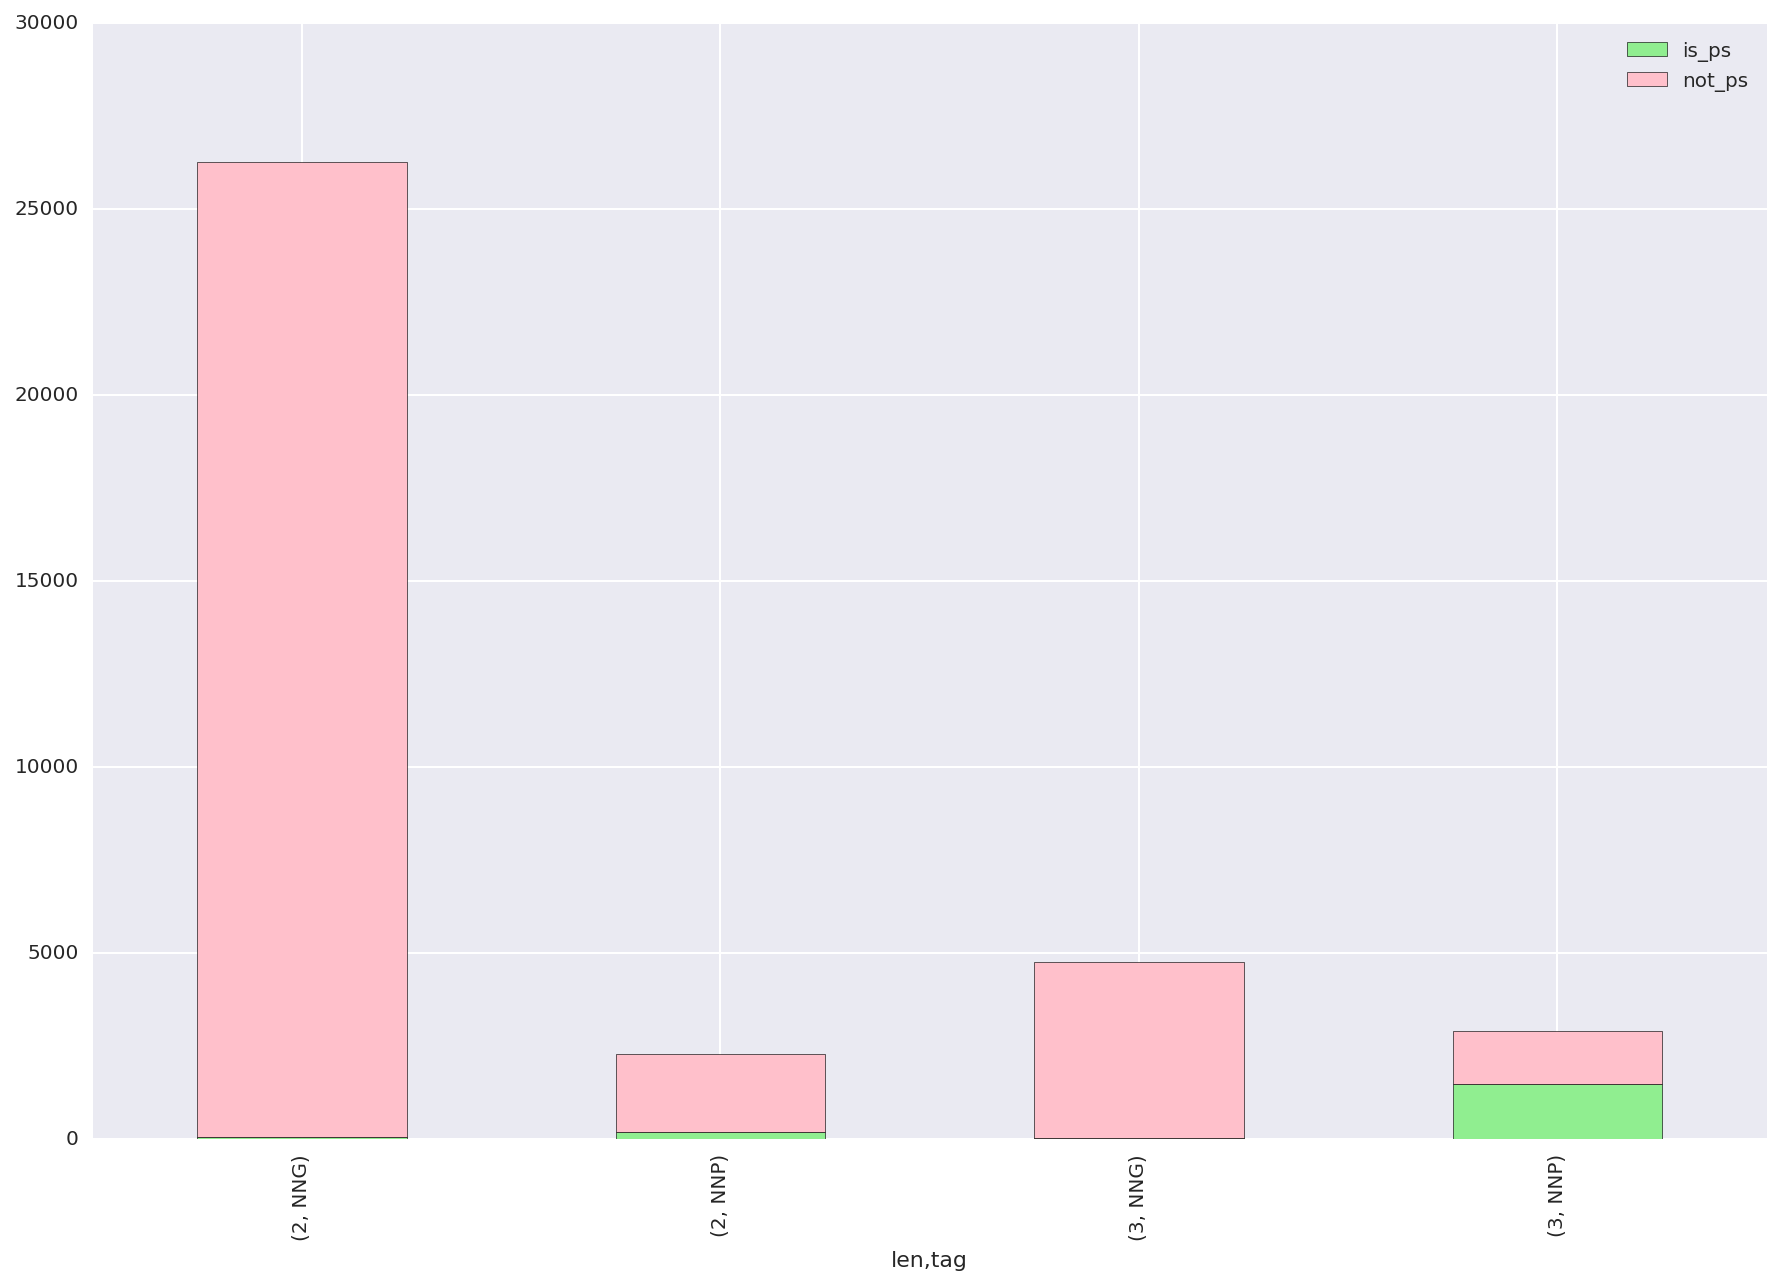

In [5]:
df_group = df.groupby(['len', 'tag']).sum()
print(df_group)
df_group.plot(kind='bar', color=['lightgreen', 'pink'], stacked=True, figsize=(15, 10))
plt.show()

결론
----

3음절 NNP인 단일 형태소의 경우 인명과 아닌 경우가 반반이며, 그 외 2음절이거나 NNG인 경우는 대부분 인명이 아니다.